# Plot Slopes

Bambi's sub-package `interpret` features a set of functions to help interpret complex regression models. The sub-package is inspired by the R package [marginaleffects](https://marginaleffects.com/chapters/predictions.html#conditional-predictions). In this notebook we will discuss two functions `slopes` and `plot_slopes`. These two functions allow the modeler to easier interpret slopes, either by a inspecting a summary output or plotting them.

Below, it is described why estimating the slope of the prediction function is useful in interpreting generalized linear models (GLMs), how this methodology is implemented in Bambi, and how to use `slopes` and `plot_slopes`. It is assumed that the reader is familiar with the basics of GLMs. If not, refer to the Bambi [Basic Building Blocks](https://bambinos.github.io/bambi/notebooks/how_bambi_works.html#Link-functions) example.

## Interpretation of Regression Coefficients

Assuming we have fit a linear regression model of the form

$$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_k x_k + \epsilon$$

the "safest" interpretation of the regression coefficients $\beta$ is as a comparison between two groups of items that differ by $1$ in the relevant predictor variable $x_i$ while being identical in all the other predictors. Formally, the predicted difference between two items $i$ and $j$ that differ by an amount $n$ on predictor $k$, but are identical on all other predictors, the predicted difference is $y_i - y_j$ is $\beta_kx$, on average.

However, once we move away from a regression model with a Gaussian response, the identity function, and no interaction terms, the interpretation of the coefficients are not as straightforward. For example, in a logistic regression model, the coefficients are on a different scale and are measured in logits (log odds), not probabilities or percentage points. Thus, you cannot interpret the coefficents as a "one unit increase in $x_k$ is associated with an $n$ percentage point decrease in $y$". First, the logits must be converted to the probability scale. Secondly, a one unit change in $x_k$ may produce a larger or smaller change in the outcome, depending upon how far away from zero the logits are. 

`slopes` and `plot_slopes`, by default, computes quantities of interest on the response scale for GLMs. For example, for a logistic regression model, this is the probability scale, and for a Poisson regression model, this is the count scale.

### Interpreting interaction effects

Specifying interactions in a regression model is a way of allowing parameters to be conditional on certain aspects of the data. By contrast, for a model with no interactions, the parameters are **not** conditional and thus, the value of one parameter is not dependent on the value of another covariate. However, once interactions exist, multiple parameters are always in play at the same time. Additionally, interactions can be specified for either categorical, continuous, or both types of covariates. Thus, making the interpretation of the parameters more difficult.

With GLMs, every covariate essentially interacts with itself because of the link function. To demonstrate parameters interacting with themselves, consider the mean of a Gaussian linear model with an identity link function

$$\mu = \alpha + \beta x$$

where the rate of change in $\mu$ with respect to $x$ is just $\beta$, i.e., the rate of change is constant no matter what the value of $x$ is. But when we consider GLMs with link functions used to map outputs to exponential family distribution parameters, calculating the derivative of the mean output $\mu$ with respect to the predictor is not as straightforward as in the Gaussian linear model. For example, computing the rate of change in a binomial probability $p$ with respect to $x$

$$p = \frac{exp(\alpha + \beta x)}{1 + exp(\alpha + \beta x)}$$

And taking the derivative of $p$ with respect to $x$ yields

$$\frac{\partial p}{\partial x} = \frac{\beta}{2(1 + cosh(\alpha + \beta x))}$$

Since $x$ appears in the derivative, the impact of a change in $x$ depends upon $x$, i.e., an interaction with itself even though no interaction term was specified in the model.Thus, visualizing the rate of change in the mean response with respect to a covariate $x$ becomes a useful tool in interpreting GLMs.

## Average Predictive Slopes

Here, we adopt the notation from Chapter 14.4 of [Regression and Other Stories](https://avehtari.github.io/ROS-Examples/) to first describe average predictive differences which is essential to computing `slopes`, and then secondly, average predictive slopes. Assume we have fit a Bambi model predicting an outcome $Y$ based on inputs $X$ and parameters $\theta$. Consider the following scalar inputs:

$$w: \text{the input of interest}$$
$$c: \text{all the other inputs}$$
$$X = (w, c)$$

In contrast to `comparisons`, for `slopes` we are interested in comparing $w^{\text{value}}$ to $w^{\text{value}+\epsilon}$ (perhaps age = 60 and 60.0001 respectively) with all other inputs $c$ held constant. The _predictive difference_ in the outcome changing **only** $w$ is:

$$\text{average predictive difference} = \mathbb{E}(y|w^{\text{value}+\epsilon}, c, \theta) - \mathbb{E}(y|w^{\text{value}}, c, \theta)$$

Selecting $w$ and $w^{\text{value}+\epsilon}$ and averaging over all other inputs $c$ in the data gives you a new "hypothetical" dataset and corresponds to counting all pairs of transitions of $(w^\text{value})$ to $(w^{\text{value}+\epsilon})$, i.e., differences in $w$ with $c$ held constant. The difference between these two terms is the average predictive difference.

However, to obtain the slope estimate, we need to take the above formula and divide by $\epsilon$ to obtain the _average predictive slope_:

$$\text{average predictive slope} = \frac{\mathbb{E}(y|w^{\text{value}+\epsilon}, c, \theta) - \mathbb{E}(y|w^{\text{value}}, c, \theta)}{\epsilon}$$

## Computing Slopes

The objective of `slopes` and `plot_slopes` is to compute the rate of change (slope) in the mean of the response $y$ with respect to a small change $\epsilon$ in the predictor $x$ conditional on other covariates $c$ specified in the model. $w$ is specified by the user and the original value is either provided by the user, else a default value (the mean) is computed by Bambi. The values for the other covariates $c$ specified in the model can be determined under the following three scenarios:

1. user provided values 
2. a grid of equally spaced and central values
3. empirical distribution (original data used to fit the model)

In the case of (1) and (2) above, Bambi assembles all pairwise combinations (transitions) of $w$ and $c$ into a new "hypothetical" dataset. In (3), Bambi uses the original $c$, and adds a small amount $\epsilon$ to each unit of observation's $w$. In each scenario, predictions are made on the data using the fitted model. Once the predictions are made, comparisons are computed using the posterior samples by taking the difference in the predicted outcome for each pair of transitions and dividing by $\epsilon$. The average of these slopes is the average predictive slopes.

For variables $w$ with a string or categorical data type, use the `comparisons` function as `slopes` expects a numeric data type to approximate the derivative via finite-differences. Please refer to the [comparisons](https://bambinos.github.io/bambi/notebooks/plot_comparisons.html) documentation for more details.

Below, we present several examples showing how to use Bambi to perform these computations for us, and to return either a summary dataframe, or a visualization of the results.

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import warnings

import bambi as bmb
from bambi.interpret import slopes, plot_slopes

warnings.simplefilter(action="ignore", category=FutureWarning)

%load_ext autoreload
%autoreload 2

## Logistic Regression

To demonstrate `slopes` and `plot_slopes`, we will use the [well switching dataset](https://vincentarelbundock.github.io/Rdatasets/doc/carData/Wells.html) to model the probability a household in Bangladesh switches water wells. The data are for an area of Arahazar Upazila, Bangladesh. The researchers labelled each well with its level of arsenic and an indication of whether the well was “safe” or “unsafe”. Those using unsafe wells were encouraged to switch. After several years, it was determined whether each household using an unsafe well had changed its well. The data contains $3020$ observations on the following five variables:

- `switch`: a factor with levels `no` and `yes` indicating whether the household switched to a new well
- `arsenic`: the level of arsenic in the old well (measured in micrograms per liter)
- `dist`: the distance to the nearest safe well (measured in meters)
- `assoc`: a factor with levels `no` and `yes` indicating whether the household is a member of an arsenic education group
- `educ`: years of education of the household head

First, a logistic regression model with no interactions is fit to the data. Subsequently, to demonstrate the benefits of `plot_slopes` in interpreting interactions, we will fit a logistic regression model with an interaction term.

In [2]:
data = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/carData/Wells.csv")
data["switch"] = pd.Categorical(data["switch"])
data["dist100"] = data["distance"] / 100
data["educ4"] = data["education"] / 4
data.head()

,rownames,switch,arsenic,distance,education,association,dist100,educ4
0,1,yes,2.36,16.826,0,no,0.16826,0.0
1,2,yes,0.71,47.322,0,no,0.47322,0.0
2,3,no,2.07,20.967,10,no,0.20967,2.5
3,4,yes,1.15,21.486,12,no,0.21486,3.0
4,5,yes,1.10,40.874,14,yes,0.40874,3.5


In [3]:
well_model = bmb.Model(
    "switch ~ dist100 + arsenic + educ4",
    data,
    family="bernoulli"
)

well_idata = well_model.fit(
    draws=1000, 
    target_accept=0.95, 
    random_seed=1234, 
    chains=4
)

Modeling the probability that switch==no
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, dist100, arsenic, educ4]


/Users/hslu-n0006897/projects/bambi/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


### User provided values

First, an example of scenario 1 (user provided values) is given below. In both `plot_slopes` and `slopes`, $w$ and $c$ are represented by `wrt` (with respect to) and `conditional`, respectively. The modeler has the ability to pass their own values for `wrt` and `conditional` by using a dictionary where the key-value pairs are the covariate and value(s) of interest.

For example, if we wanted to compute the slope of the probability of switching wells for a typical `arsenic` value of $1.3$ conditional on a range of `dist` and `educ` values, we would pass the following dictionary in the code block below. By default, for $w$, Bambi compares $w^\text{value}$ to $w^{\text{value} + \epsilon}$ where $\epsilon =$ `1e-4`. However, the value for $\epsilon$ can be changed by passing a value to the argument `eps`. 

Thus, in this example, $w^\text{value} = 1.3$ and $w^{\text{value} + \epsilon} = 1.3001$. The user is not limited to passing a list for the values. A `np.array` can also be used. Furthermore, Bambi by default, maps the order of the dict keys to the main, group, and panel of the matplotlib figure. Below, since `dist100` is the first key, this is used for the x-axis, and `educ4` is used for the group (color). If a third key was passed, it would be used for the panel (facet).

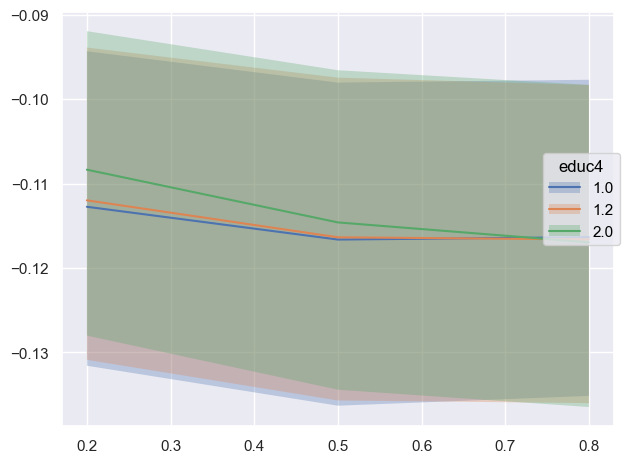

In [4]:
plot = plot_slopes(
    well_model,
    well_idata,
    wrt={"arsenic": 1.3},
    conditional={"dist100": [0.20, 0.50, 0.80], "educ4": [1.00, 1.20, 2.00]},
)
# fig.axes[0].set_ylabel("Slope of Well Switching Probability");

The plot above shows that, for example, conditional on `dist100` $= 0.2$ and `educ4` $= 1.0$ a unit increase in `arsenic` is associated with households being $11$% less likely to switch wells. Notice that even though we fit a logistic regression model where the coefficients are on the log-odds scale, the `slopes` function returns the slope on the probability scale. Thus, we can interpret the y-axis (slope) as the expected change in the probability of switching wells for a unit increase in `arsenic` conditional on the specified covariates.

`slopes` can be called directly to view a summary dataframe that includes the term name, estimate type (discussed in detail in the _interpreting coefficients as an elasticity_ section), values $w$ used to compute the estimate, the specified conditional covariates $c$, and the expected slope of the outcome with the uncertainty interval (by default the $94$% highest density interval is computed).

In [5]:
result = slopes(
    well_model,
    well_idata,
    wrt={"arsenic": 1.5},
    conditional={
        "dist100": [0.20, 0.50, 0.80],
        "educ4": [1.00, 1.20, 2.00]
    }
)

result.summary

,term,estimate_type,value,dist100,educ4,estimate,lower_3.0%,upper_97.0%
0,arsenic,dydx,1.5,0.2,1.0,-0.110501,-0.128753,-0.092899
1,arsenic,dydx,1.5,0.2,1.2,-0.109584,-0.127565,-0.092048
2,arsenic,dydx,1.5,0.2,2.0,-0.105399,-0.123199,-0.088894
3,arsenic,dydx,1.5,0.5,1.0,-0.115731,-0.135337,-0.097521
4,arsenic,dydx,1.5,0.5,1.2,-0.115280,-0.134801,-0.097199
5,arsenic,dydx,1.5,0.5,2.0,-0.112818,-0.131913,-0.095104
6,arsenic,dydx,1.5,0.8,1.0,-0.116923,-0.136423,-0.098302
7,arsenic,dydx,1.5,0.8,1.2,-0.117001,-0.136475,-0.098365
8,arsenic,dydx,1.5,0.8,2.0,-0.116597,-0.135591,-0.097564


Since all covariates used to fit the model were also specified to compute the slopes, no default value is used for unspecified covariates. A default value is computed for the unspecified covariates because in order to peform predictions, Bambi is expecting a value for each covariate used to fit the model. Additionally, with GLM models, average predictive slopes are conditional in the sense that the estimate depends on the values of **all** the covariates in the model. Thus, for unspecified covariates, `slopes` and `plot_slopes` computes a default value (mean or mode based on the data type of the covariate). Each row in the summary dataframe is read as "the slope (or rate of change) of the probability of switching wells with respect to a small change in $w$ conditional on $c$ is $y$".

### Conditional slopes

As stated in the _interpreting interaction effects_ section, interpreting coefficients of multiple interaction terms can be difficult and cumbersome. Thus, `plot_slopes` provides an effective way to visualize the conditional slopes of the interaction effects. Below, we will use the same well switching dataset, but with interaction terms. Specifically, one interaction is added between `dist100` and `educ4`, and another between `arsenic` and `educ4`.

In [6]:
well_model_interact = bmb.Model(
    "switch ~ dist100 + arsenic + educ4 + dist100:educ4 + arsenic:educ4",
    data=data,
    family="bernoulli"
)

well_idata_interact = well_model_interact.fit(
    draws=500, 
    tune=500,
    target_accept=0.95, 
    random_seed=1234, 
    chains=4
)

Modeling the probability that switch==no
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, dist100, arsenic, educ4, dist100:educ4, arsenic:educ4]


/Users/hslu-n0006897/projects/bambi/.venv/lib/python3.13/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


In [7]:
# summary of coefficients
az.summary(well_idata_interact)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.089,0.121,-0.304,0.151,0.003,0.002,1260.0,1151.0,1.0
dist100,1.317,0.174,0.977,1.623,0.005,0.004,1103.0,1217.0,1.0
arsenic,-0.402,0.061,-0.517,-0.295,0.002,0.001,919.0,1021.0,1.0
educ4,0.095,0.078,-0.050,0.235,0.002,0.002,1075.0,1137.0,1.0
dist100:educ4,-0.328,0.107,-0.528,-0.124,0.003,0.002,1102.0,1074.0,1.0
arsenic:educ4,-0.076,0.043,-0.156,0.004,0.001,0.001,932.0,897.0,1.0


The coefficients of the linear model are shown in the table above. The interaction coefficents indicate the slope varies in a continuous fashion with the continuous variable.

A negative value for `arsenic:dist100` indicates that the "effect" of arsenic on the outcome is less negative as distance from the well increases. Similarly, a negative value for `arsenic:educ4` indicates that the "effect" of arsenic on the outcome is more negative as education increases. Remember, these coefficients are still on the logit scale. Furthermore, as more variables and interaction terms are added to the model, interpreting these coefficients becomes more difficult. 

Thus, lets use `plot_slopes` to visually see how the slope changes with respect to `arsenic` conditional on `dist100` and `educ4` changing. Notice in the code block below how parameters are passed to the `subplot_kwargs` and `fig_kwargs` arguments. At times, it can be useful to pass specific `group` and `panel` arguments to aid in the interpretation of the plot. Therefore, `subplot_kwargs` allows the user to manipulate the plotting by passing a dictionary where the keys are `{"main": ..., "group": ..., "panel": ...}` and the values are the names of the covariates to be plotted. `fig_kwargs` are figure level key word arguments such as a theme dictionary (dictionary of matplotlib rc parameters).

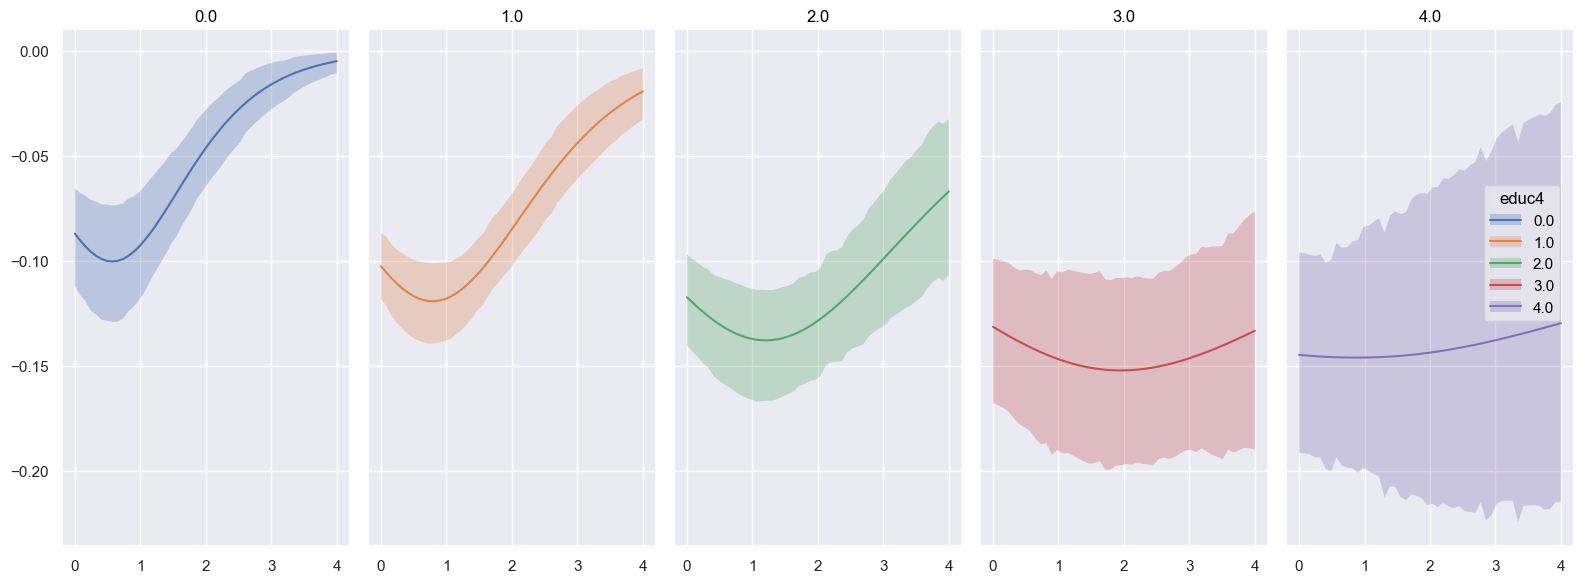

In [8]:
plot = plot_slopes(
    well_model_interact,
    well_idata_interact,
    wrt="arsenic",
    conditional={
        "dist100": np.linspace(0, 4, 50),
        "educ4": np.arange(0, 5, 1)
    },
    subplot_kwargs={"main": "dist100", "group": "educ4", "panel": "educ4"},
    fig_kwargs={"theme": {"figure.figsize": (16, 6)}},
)

With interaction terms now defined, it can be seen how the slope of the outcome with respect to `arsenic` differ depending on the value of `educ4`. Especially in the case of `educ4` $= 4.25$, the slope is more "constant", but with greater uncertainty. Lets compare this with the model that does not include any interaction terms.

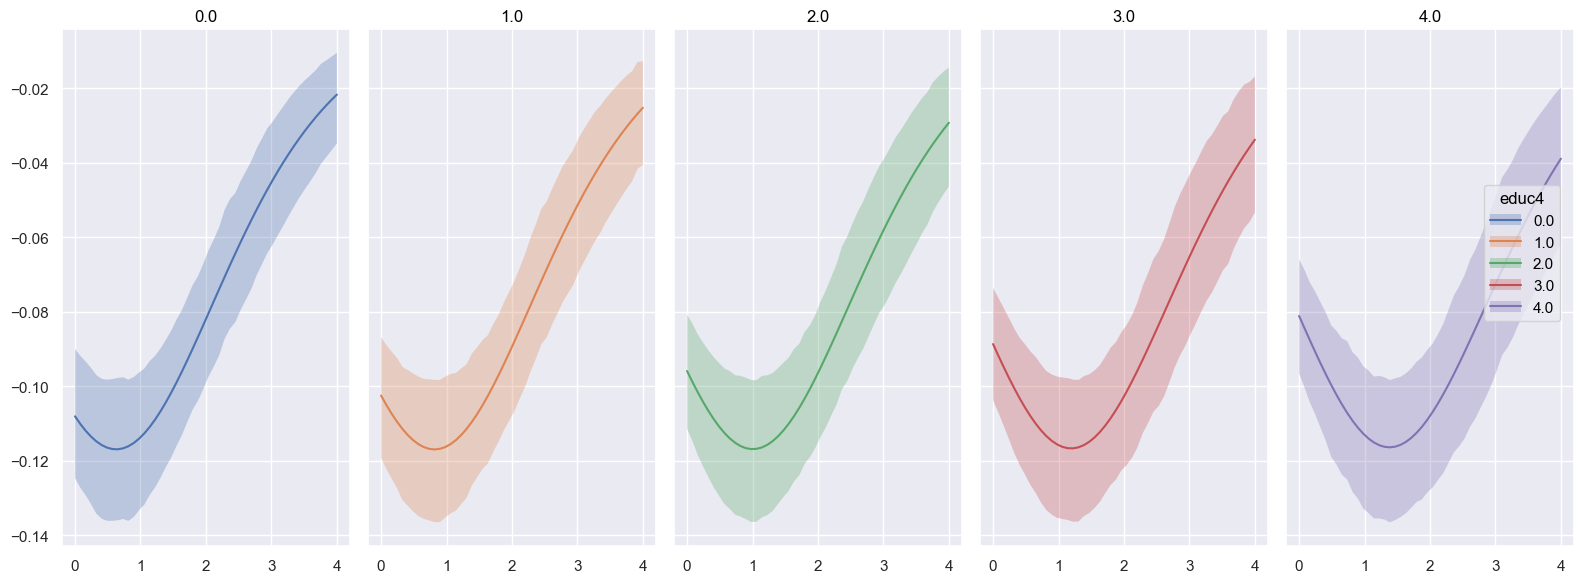

In [9]:
plot = plot_slopes(
    well_model,
    well_idata,
    wrt="arsenic",
    conditional={
        "dist100": np.linspace(0, 4, 50),
        "educ4": np.arange(0, 5, 1)
    },
    subplot_kwargs={"main": "dist100", "group": "educ4", "panel": "educ4"},
    fig_kwargs={"theme": {"figure.figsize": (16, 6)}},
)

For the non-interaction model, conditional on a range of values for `educ4` and `dist100`, the slopes of the outcome are nearly identical.

### Unit level slopes

Evaluating average predictive slopes at central values for the conditional covariates $c$ can be problematic when the inputs have a large variance since no single central value (mean, median, etc.) is representative of the covariate. This is especially true when $c$ exhibits bi or multimodality. Thus, it may be desireable to use the empirical distribution of $c$ to compute the predictive slopes, and then average over a specific or set of covariates to obtain average slopes. To achieve unit level slopes, do not pass a parameter into `conditional` and or specify `None`.

In [10]:
unit_level = slopes(
    well_model_interact,
    well_idata_interact,
    wrt="arsenic",
    conditional=None
)

# empirical distribution
print(unit_level.summary.shape[0] == well_model_interact.data.shape[0])
unit_level.summary.head(10)

True


,term,estimate_type,value,dist100,educ4,estimate,lower_3.0%,upper_97.0%
0,arsenic,dydx,1.65693,0.16826,0.00,-0.093419,-0.119679,-0.068985
1,arsenic,dydx,1.65693,0.47322,0.00,-0.099893,-0.128482,-0.073140
2,arsenic,dydx,1.65693,0.20967,2.50,-0.129538,-0.159986,-0.102402
3,arsenic,dydx,1.65693,0.21486,3.00,-0.135338,-0.172074,-0.101712
4,arsenic,dydx,1.65693,0.40874,3.50,-0.142571,-0.188180,-0.102318
5,arsenic,dydx,1.65693,0.69518,2.25,-0.136726,-0.167590,-0.109550
6,arsenic,dydx,1.65693,0.80711,1.00,-0.119250,-0.139402,-0.101189
7,arsenic,dydx,1.65693,0.55146,2.50,-0.136691,-0.171831,-0.109113
8,arsenic,dydx,1.65693,0.52647,0.00,-0.100231,-0.128745,-0.073181
9,arsenic,dydx,1.65693,0.75072,0.00,-0.098899,-0.127263,-0.072467


In [11]:
well_model_interact.data.head(10)

,rownames,switch,arsenic,distance,education,association,dist100,educ4
0,1,yes,2.36,16.826,0,no,0.16826,0.00
1,2,yes,0.71,47.322,0,no,0.47322,0.00
2,3,no,2.07,20.967,10,no,0.20967,2.50
3,4,yes,1.15,21.486,12,no,0.21486,3.00
4,5,yes,1.10,40.874,14,yes,0.40874,3.50
5,6,yes,3.90,69.518,9,yes,0.69518,2.25
6,7,yes,2.97,80.711,4,yes,0.80711,1.00
7,8,yes,3.24,55.146,10,no,0.55146,2.50
8,9,yes,3.28,52.647,0,yes,0.52647,0.00
9,10,yes,2.52,75.072,0,yes,0.75072,0.00


Above, `unit_level` is the slopes summary dataframe and `well_model_interact.data` is the empirical data used to fit the model. Notice how the values for $c$ are identical in both dataframes. However, for $w$, the values are the original $w$ value plus $\epsilon$. Thus, the `estimate` value represents the instantaneous rate of change for that unit of observation. However, these unit level slopes are difficult to interpret since each row may have a different slope estimate. Therefore, it is useful to average over (marginalize) the estimates to summarize the unit level predictive slopes.

#### Marginalizing over covariates

Since the empirical distrubution is used for computing the average predictive slopes, the same number of rows ($3020$) is returned as the data used to fit the model. To average over a covariate, use the `average_by` argument. If `all` is passed, then `slopes` averages over **all** covariates. Else, if a single or list of covariates are passed, then `slopes` averages by the covariates passed.

In [12]:
result = slopes(
    well_model_interact,
    well_idata_interact,
    wrt="arsenic",
    conditional=None,
    average_by="all"
)

result.summary

,term,estimate_type,value,estimate,lower_3.0%,upper_97.0%
0,arsenic,dydx,1.65693,-0.114508,-0.139836,-0.091411


The code block above is equivalent to taking the mean of the `estimate` and uncertainty columns. For example:

In [13]:
unit_level.summary[["estimate", "lower_3.0%", "upper_97.0%"]].mean()

estimate      -0.114508
lower_3.0%    -0.139836
upper_97.0%   -0.091411
dtype: float64

#### Average by subgroups

Averaging over all covariates may not be desired, and you would rather average by a group or specific covariate. To perform averaging by subgroups, users can pass a single or list of covariates to `average_by` to average over specific covariates. For example, if we wanted to average by `educ4`:

In [14]:
# average by educ4
result = slopes(
    well_model_interact,
    well_idata_interact,
    wrt="arsenic",
    conditional=None,
    average_by="educ4"
)

result.summary

,term,estimate_type,value,educ4,estimate,lower_3.0%,upper_97.0%
0,arsenic,dydx,1.65693,0.00,-0.094647,-0.121600,-0.069330
1,arsenic,dydx,1.65693,0.25,-0.099936,-0.124430,-0.078709
2,arsenic,dydx,1.65693,0.50,-0.104290,-0.126271,-0.084984
3,arsenic,dydx,1.65693,0.75,-0.108319,-0.127947,-0.090309
4,arsenic,dydx,1.65693,1.00,-0.112876,-0.131901,-0.095924
5,arsenic,dydx,1.65693,1.25,-0.117014,-0.136409,-0.100036
6,arsenic,dydx,1.65693,1.50,-0.121139,-0.141364,-0.102163
7,arsenic,dydx,1.65693,1.75,-0.124711,-0.147667,-0.104532
8,arsenic,dydx,1.65693,2.00,-0.127584,-0.153116,-0.105311
9,arsenic,dydx,1.65693,2.25,-0.132024,-0.160573,-0.105925


In [15]:
# average by both educ4 and dist100
result = slopes(
    well_model_interact,
    well_idata_interact,
    wrt="arsenic",
    conditional=None,
    average_by=["educ4", "dist100"]
)

result.summary

,term,estimate_type,value,educ4,dist100,estimate,lower_3.0%,upper_97.0%
0,arsenic,dydx,1.65693,0.00,0.00591,-0.087354,-0.112697,-0.065787
1,arsenic,dydx,1.65693,0.00,0.02409,-0.088103,-0.113070,-0.065835
2,arsenic,dydx,1.65693,0.00,0.02454,-0.088121,-0.113095,-0.065847
3,arsenic,dydx,1.65693,0.00,0.02791,-0.088258,-0.113283,-0.065937
4,arsenic,dydx,1.65693,0.00,0.03252,-0.088445,-0.113552,-0.066059
...,...,...,...,...,...,...,...,...
2992,arsenic,dydx,1.65693,4.00,1.13727,-0.145963,-0.201388,-0.081699
2993,arsenic,dydx,1.65693,4.00,1.14418,-0.145956,-0.201537,-0.081359
2994,arsenic,dydx,1.65693,4.00,1.25308,-0.145825,-0.203271,-0.079612
2995,arsenic,dydx,1.65693,4.00,1.67025,-0.144902,-0.214549,-0.075927


It is still possible to use `plot_slopes` when passing an argument to `average_by`. In the plot below, the empirical distribution is used to compute unit level slopes with respect to `arsenic` and then averaged over `educ4` to obtain the average predictive slopes.

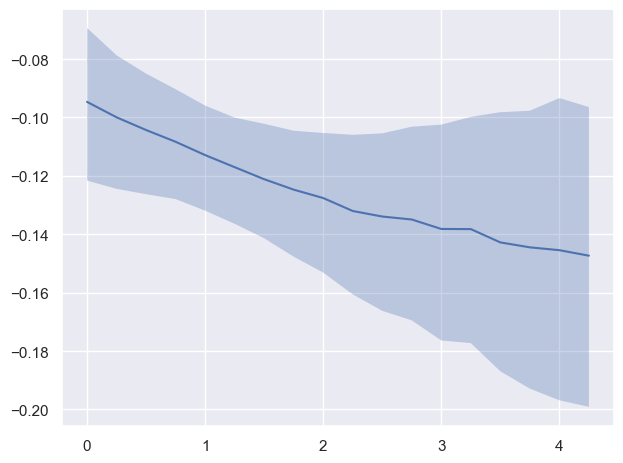

In [16]:
plot = plot_slopes(
    well_model_interact,
    well_idata_interact,
    wrt="arsenic",
    conditional=None,
    average_by="educ4"
)

### Interpreting coefficients as an elasticity

In some fields, such as economics, it is useful to interpret the results of a regression model in terms of an elasticity (a percent change in $x$ is associated with a percent change in $y$) or semi-elasticity (a unit change in $x$ is associated with a percent change in $y$, or vice versa). Typically, this is achieved by fitting a model where either the outcome and or the covariates are log-transformed. However, since the log transformation is performed by the modeler, to compute elasticities for `slopes` and `plot_slopes`, Bambi "post-processes" the predictions to compute the elasticities. Below, it is shown the possible elasticity arguments and how they are computed for `slopes` and `plot_slopes`:

- `eyex`: a percentage point increase in $x_1$ is associated with an $n$ percentage point increase in $y$

$$\frac{\partial \hat{y}}{\partial x_1} * \frac{x_1}{\hat{y}}$$

- `eydx`: a unit increase in $x_1$ is associated with an $n$ percentage point increase in $y$

$$\frac{\partial \hat{y}}{\partial x_1} * \frac{1}{\hat{y}}$$

- `dyex`: a percentage point increase in $x_1$ is associated with an $n$ unit increase in $y$

$$\frac{\partial \hat{y}}{\partial x_1} * x_1$$

Below, each code cell shows the same model, and `wrt` and `conditional` argument, but with a different elasticity (`slope`) argument. By default, `dydx` (a derivative with no post-processing) is used.

In [17]:
result = slopes(
    well_model_interact,
    well_idata_interact,
    wrt="arsenic",
    slope="eyex",
    conditional=None,
    average_by="all"
)

result.summary

,term,estimate_type,value,estimate,lower_3.0%,upper_97.0%
0,arsenic,eyex,1.65693,-0.482788,-0.597584,-0.37511


In [18]:
result = bmb.interpret.slopes(
    well_model_interact,
    well_idata_interact,
    wrt="arsenic",
    slope="eydx",
    conditional=None,
    average_by="all"
)

result.summary

,term,estimate_type,value,estimate,lower_3.0%,upper_97.0%
0,arsenic,eydx,1.65693,-0.291375,-0.360657,-0.226389


In [19]:
result = slopes(
    well_model_interact,
    well_idata_interact,
    wrt="arsenic",
    slope="dyex",
    conditional=None,
    average_by="all"
)

result.summary

,term,estimate_type,value,estimate,lower_3.0%,upper_97.0%
0,arsenic,dyex,1.65693,-0.189732,-0.231698,-0.151462


`slope` is also an argument for `plot_slopes`. Below, we visualize the elasticity with respect to `arsenic` conditional on a range of `dist100` and `educ4` values (notice this is the same plot as in the _conditional slopes_ section).

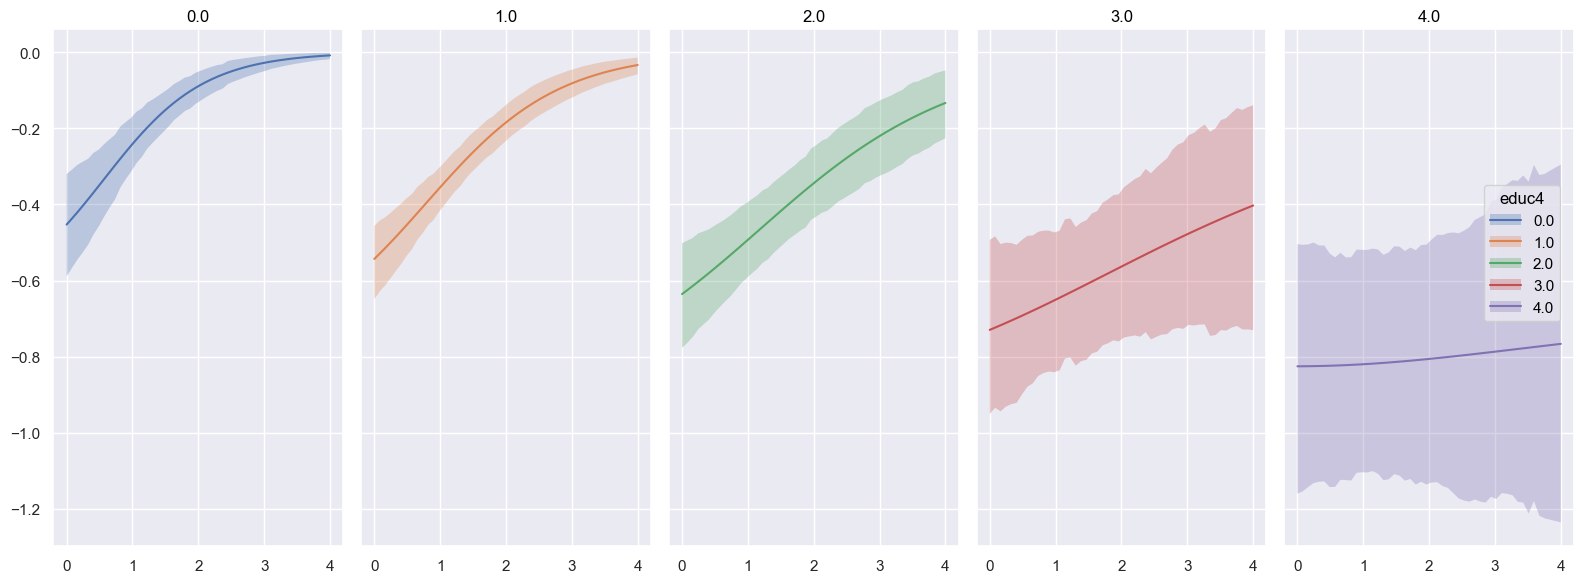

In [20]:
plot = plot_slopes(
    well_model_interact,
    well_idata_interact,
    wrt="arsenic",
    conditional={
        "dist100": np.linspace(0, 4, 50),
        "educ4": np.arange(0, 5, 1)
    },
    slope="eyex",
    subplot_kwargs={"main": "dist100", "group": "educ4", "panel": "educ4"},
    fig_kwargs={"theme": {"figure.figsize": (16, 6)}}
)

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w

ModuleNotFoundError: No module named 'watermark'